# Discovering Topics from Voted Sentences

This notebook walks through a complete pipeline for extracting **topics** from a collection of single-sentence submissions that have been rated by participants. Each sentence can be voted on with one of three outcomes: **agree** (1), **disagree** (-1), or **pass/no opinion** (0). Participants joined at different times and new sentences were added over time, so some sentences were never exposed to earlier participants.  

The pipeline addresses several challenges:

1. **Semantic deduplication:** multiple sentences may express the same idea; we group paraphrases into a single cluster before analysing votes.
2. **Exposure modelling:** because participants see only a subset of sentences (and exposure is not uniform), we model the probability that a participant has seen a sentence and correct for this in the vote-based embeddings.
3. **Signed matrix factorization with propensity weighting:** we learn low-dimensional representations of sentences based on participants' votes, using inverse-propensity weights to remove exposure bias and a special treatment for pass votes.
4. **Feature fusion and clustering:** we combine vote-derived embeddings with semantic sentence embeddings and cluster them using a density-based algorithm. An agglomerative step builds a hierarchy of topics.
5. **Topic labeling and social statistics:** we label clusters with keywords (via c‑TF‑IDF), show representative sentences, and summarise each topic with the distribution of agree/disagree/pass votes.

Throughout the notebook we provide commentary to explain each step and choices made. Feel free to adjust hyperparameters, thresholds and weighting schemes to your data and domain.


## Installation (optional)

The environment used to run this notebook may already have the necessary libraries installed. If you encounter import errors, uncomment the following lines and run them to install the required packages:

```python
# !pip install sentence-transformers hdbscan umap-learn faiss-cpu networkx scikit-learn
```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# Attempt to read the data exported from pol.is. If unavailable, fall back to a synthetic dataset.
comments_path = Path("comments.csv")
votes_path = Path("votes.csv")

if comments_path.exists() and votes_path.exists():
    comments_raw = pd.read_csv(comments_path)
    votes_raw = pd.read_csv(votes_path)

    # Normalise column names and timestamps
    sentences_df = comments_raw.rename(
        columns={
            "comment-id": "sentence_id",
            "comment-body": "text",
            "author-id": "author_id",
        }
    ).copy()
    sentences_df["timestamp"] = pd.to_datetime(
        sentences_df["timestamp"], unit="s", errors="coerce"
    )
    sentences_df = sentences_df[["sentence_id", "text", "timestamp", "author_id", "agrees", "disagrees", "moderated"]]
    sentences_df.sort_values("timestamp", inplace=True)

    votes_df = votes_raw.rename(
        columns={
            "comment-id": "sentence_id",
            "voter-id": "participant_id",
        }
    ).copy()
    votes_df["timestamp"] = pd.to_datetime(
        votes_df["timestamp"], unit="s", errors="coerce"
    )
    votes_df = votes_df[["participant_id", "sentence_id", "vote", "timestamp"]]
    votes_df.sort_values(["participant_id", "timestamp"], inplace=True)

    print(f"Loaded {len(sentences_df)} comments and {len(votes_df)} votes from pol.is export.")
else:
    print("Could not load pol.is export; generating a synthetic dataset instead.")
    # Synthetic dataset parameters
    num_sentences = 128
    num_participants = 60
    np.random.seed(0)
    # Create synthetic sentences with timestamps spread over 4 months
    base_time = np.datetime64("2025-01-01")
    times = base_time + np.random.randint(0, 120, size=num_sentences).astype("timedelta64[D]")
    sentences_df = pd.DataFrame(
        {
            "sentence_id": np.arange(num_sentences),
            "text": [f"Synthetic sentence {i}" for i in range(num_sentences)],
            "timestamp": times,
        }
    )
    # Generate participant join times randomly over the same period
    join_times = base_time + np.random.randint(0, 120, size=num_participants).astype("timedelta64[D]")
    # Synthetic votes: each participant votes on sentences added before they joined, with random agree/disagree/pass
    votes_records = []
    for p, join_time in enumerate(join_times):
        eligible_sentences = sentences_df[sentences_df["timestamp"] <= join_time]
        chosen = eligible_sentences.sample(frac=0.5, random_state=p)
        for _, row in chosen.iterrows():
            vote = np.random.choice([1, -1, 0], p=[0.5, 0.3, 0.2])
            votes_records.append(
                {
                    "participant_id": p,
                    "sentence_id": row["sentence_id"],
                    "vote": vote,
                    "timestamp": join_time,
                }
            )
    votes_df = pd.DataFrame(votes_records)
    votes_df["timestamp"] = pd.to_datetime(votes_df["timestamp"])
    print("Synthetic dataset created.")

sentences_df.head(), votes_df.head()


Loaded 61 comments and 4538 votes from pol.is export.


(    sentence_id                                               text  \
 6             0       FAccT should be open and welcoming community   
 7             1  FAccT should be a generator for alternative so...   
 8             2  FAccT is NOT doing well in inviting “non-acade...   
 9             3                  FAccT should have poster sessions   
 10            4  Facct is not inclusive to the local country/co...   
 
              timestamp  author_id  agrees  disagrees  moderated  
 6  2025-06-26 12:52:10          0      87          1          1  
 7  2025-06-26 12:53:45          0      42         19          1  
 8  2025-06-26 12:53:49          0      37         25          1  
 9  2025-06-26 12:53:54          0      61         12          1  
 10 2025-06-26 12:53:59          0      22         19          1  ,
       participant_id  sentence_id  vote           timestamp
 0                  0            0     1 2025-06-29 12:00:08
 3108               0           33     1 2025-0

## Data Overview

Before diving into deduplication and modelling, we take a quick look at participation levels and the cadence of new submissions.

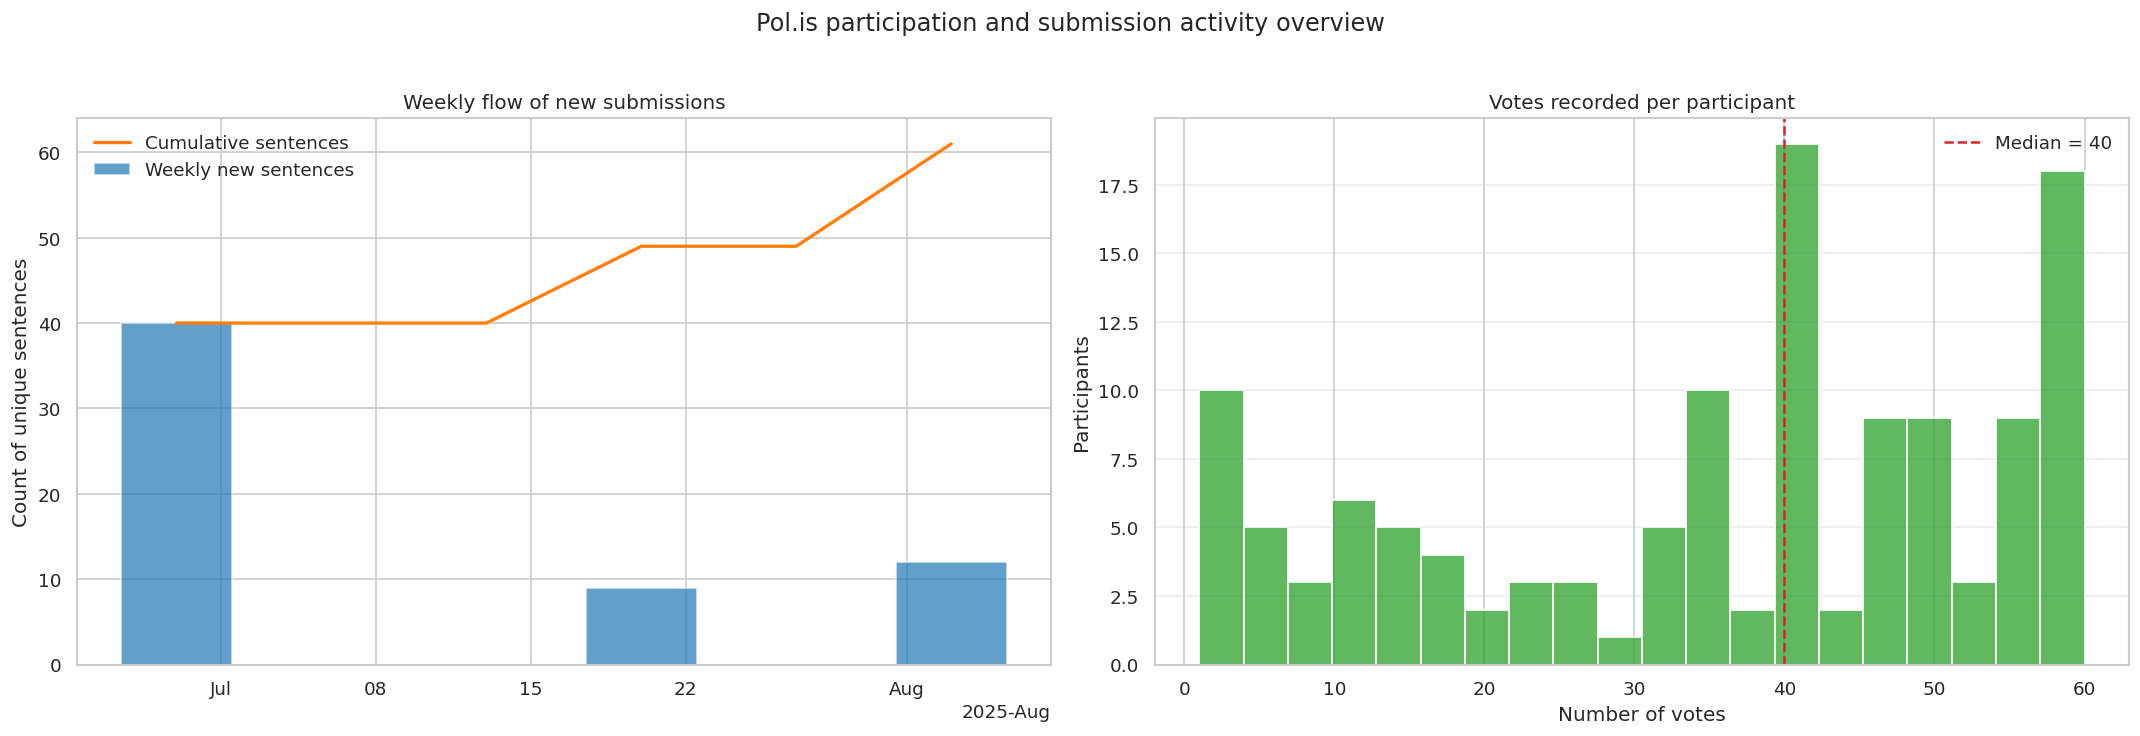

In [2]:
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

if sentences_df["timestamp"].notna().any():
    comment_timeline = (
        sentences_df.dropna(subset=["timestamp"])
        .set_index("timestamp")["sentence_id"]
        .resample("W")
        .nunique()
        .rename("unique_sentences")
    )
    cumulative = comment_timeline.cumsum()
    axes[0].bar(
        comment_timeline.index,
        comment_timeline.values,
        width=5,
        color="#1f77b4",
        alpha=0.7,
        label="Weekly new sentences",
    )
    axes[0].plot(
        comment_timeline.index,
        cumulative.values,
        color="#ff7f0e",
        linewidth=2,
        label="Cumulative sentences",
    )
    locator = AutoDateLocator()
    axes[0].xaxis.set_major_locator(locator)
    axes[0].xaxis.set_major_formatter(ConciseDateFormatter(locator))
    axes[0].set_title("Weekly flow of new submissions")
    axes[0].set_ylabel("Count of unique sentences")
    axes[0].legend(frameon=False)
else:
    axes[0].axis("off")
    axes[0].text(
        0.5,
        0.5,
        "No timestamps available for sentences.",
        ha="center",
        va="center",
        fontsize=12,
    )

votes_per_participant = votes_df.groupby("participant_id")["vote"].count()
if not votes_per_participant.empty:
    sns.histplot(votes_per_participant, bins=20, color="#2ca02c", ax=axes[1])
    median_votes = votes_per_participant.median()
    axes[1].axvline(
        median_votes,
        color="#d62728",
        linestyle="--",
        label=f"Median = {median_votes:.0f}",
    )
    axes[1].set_title("Votes recorded per participant")
    axes[1].set_xlabel("Number of votes")
    axes[1].set_ylabel("Participants")
    axes[1].legend(frameon=False)
    axes[1].grid(axis="y", alpha=0.4)
else:
    axes[1].axis("off")
    axes[1].text(
        0.5,
        0.5,
        "No participant vote activity available.",
        ha="center",
        va="center",
        fontsize=12,
    )

plt.suptitle("Pol.is participation and submission activity overview", y=1.02)
plt.tight_layout()
plt.show()


## 1. Semantic Deduplication

Multiple participants may express the same idea using different words. Before aggregating votes, we group **paraphrases** into single units called *groups*. Our deduplication strategy proceeds in two stages:

1. **Bi‑encoder retrieval:** We embed each sentence with a sentence‑level transformer (e.g. `all‑mpnet‑base‑v2`) and use cosine similarity to find candidate paraphrase pairs. Embedding similarity is fast and yields high recall but may include false positives.
2. **Cross‑encoder re‑ranking:** We pass each candidate pair through a more accurate cross‑encoder model (e.g. `ms‑marco‑MiniLM‑L‑6‑v2`). This network jointly processes both sentences and predicts a similarity score. We keep pairs above a chosen threshold as paraphrases.

The union of verified paraphrase pairs forms a graph; each connected component corresponds to one semantic group.  

If the `sentence-transformers` or `networkx` packages are unavailable, this step gracefully degrades by skipping deduplication (each sentence becomes its own group).


In [3]:
# Attempt to import sentence-transformers. If unavailable, deduplication will be skipped.
try:
    from sentence_transformers import CrossEncoder, SentenceTransformer, util
except ImportError as e:
    print("sentence-transformers not available:", e)
    SentenceTransformer = None
    util = None
    CrossEncoder = None

# Compute bi‑encoder embeddings if possible
bi_encoder = None
sent_emb = None
if SentenceTransformer is not None:
    try:
        bi_encoder = SentenceTransformer("all-mpnet-base-v2")
        sent_emb = bi_encoder.encode(
            sentences_df["text"].tolist(),
            convert_to_tensor=True,
            normalize_embeddings=True,
        )
    except Exception as e:
        print("Bi‑encoder unavailable or failed:", e)
        bi_encoder = None
        sent_emb = None

# Identify candidate paraphrase pairs using embedding similarity
paraphrase_pairs = []
if sent_emb is not None and util is not None:
    candidates = util.paraphrase_mining_embeddings(sent_emb, top_k=20)
    COS_THRESHOLD = 0.80
    paraphrase_pairs = [(i, j) for score, i, j in candidates if score >= COS_THRESHOLD]

# Refine pairs using cross‑encoder
verified_pairs = []
if paraphrase_pairs:
    if CrossEncoder is not None:
        try:
            ce_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
            texts = sentences_df["text"].tolist()
            pair_texts = [(texts[i], texts[j]) for i, j in paraphrase_pairs]
            ce_scores = ce_model.predict(pair_texts)
            CE_THRESHOLD = 0.50
            verified_pairs = [
                (i, j)
                for (i, j), s in zip(paraphrase_pairs, ce_scores)
                if s >= CE_THRESHOLD
            ]
        except Exception as e:
            print("Cross‑encoder unavailable or failed:", e)
            verified_pairs = paraphrase_pairs.copy()
    else:
        verified_pairs = paraphrase_pairs.copy()

# Build connected components of paraphrase graph
try:
    import networkx as nx

    G = nx.Graph()
    G.add_nodes_from(range(len(sentences_df)))
    G.add_edges_from(verified_pairs)
    components = list(nx.connected_components(G))
except Exception as e:
    print("networkx unavailable or dedup skipped:", e)
    components = [{i} for i in range(len(sentences_df))]

# Assign a group_id per sentence
group_mapping = {}
for cid, comp in enumerate(components):
    for idx in comp:
        sid = sentences_df.iloc[idx]["sentence_id"]
        group_mapping[sid] = cid
sentences_df["group_id"] = sentences_df["sentence_id"].map(group_mapping)

# Merge group_id into votes_df
votes_df = votes_df.merge(
    sentences_df[["sentence_id", "group_id"]], on="sentence_id", how="left"
)

print(f"Deduplication complete: {len(components)} groups identified.")


/root/.cache/pypoetry/virtualenvs/taking-stock-facct-xWlJi2Mp-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Deduplication complete: 60 groups identified.


## 2. Eligibility and Exposure Propensity

Participants joined at various times; sentences were added over time. A participant *cannot* vote on a sentence that was submitted after they left the study. To correct for this **structural missingness**, we build an *eligibility matrix* `E` where `E[i, g] = 1` if participant `i` could have seen sentence group `g`, and `0` otherwise.

Within the eligible pairs there is still **selection bias**: some sentences may be more likely to be shown or noticed than others. We model the probability that an eligible participant votes on a sentence using logistic regression.

Features used in the exposure model:

* `sentence_age`: time difference (in days) between the participant’s last vote and the sentence’s submission.
* `active_days`: the span (in days) of each participant’s activity (last vote minus first vote).

The binary target is 1 if the participant voted on the sentence, 0 otherwise. The resulting predicted probability `p_hat` serves as our **propensity score**. If `scikit-learn` is unavailable, we fall back to a simple ratio: for each group, `p_hat = (# voters)/(# eligible)`.

In the vote-embedding stage we now compare two importance-weighting schemes: `1 / p_hat` retains the original inverse-propensity weighting, while `1 / n_votes` emphasises groups that collected fewer responses. The notebook quantifies both so we can select the approach that reconstructs observed votes more faithfully.


In [4]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Compute last and first vote times per participant
last_vote_time = votes_df.groupby("participant_id")["timestamp"].max()
first_vote_time = votes_df.groupby("participant_id")["timestamp"].min()
participant_active_days = (last_vote_time - first_vote_time).dt.total_seconds() / (24 * 3600.0)
participant_total_votes = votes_df.groupby("participant_id")["vote"].size()
participant_unique_groups = votes_df.groupby("participant_id")["group_id"].nunique()

# Group-level aggregates capture statement visibility in the room
group_total_votes = votes_df.groupby("group_id")["vote"].size()
group_unique_voters = votes_df.groupby("group_id")["participant_id"].nunique()

# Sentence order metadata (used as proxies for discussion recency)
sentence_order = sentences_df.sort_values("timestamp").reset_index(drop=True)
sentence_rank_map = {row.group_id: idx + 1 for idx, row in sentence_order.iterrows()}
sentence_fraction_map = {
    row.group_id: (idx + 1) / len(sentence_order) if len(sentence_order) else 0.0
    for idx, row in sentence_order.iterrows()
}

# Eligibility matrix: participants x group_id
users = votes_df["participant_id"].unique()
groups = sentences_df["group_id"].unique()
eligibility = pd.DataFrame(False, index=users, columns=groups)

# Map group to sentence timestamp
group_time_map = sentences_df.set_index("group_id")["timestamp"].to_dict()

# Populate eligibility: participant can see group if their last vote is after sentence timestamp
for u in users:
    last_time = last_vote_time[u]
    for g in groups:
        if pd.notna(last_time) and pd.notna(group_time_map[g]) and last_time >= group_time_map[g]:
            eligibility.loc[u, g] = True


# Helper to summarise diagnostic metrics

def summarize_propensity_fit(y_true, y_prob):
    metrics = {
        "n_pairs": int(len(y_true)),
        "n_votes": int(y_true.sum()),
    }
    if len(y_true) == 0:
        metrics.update({"roc_auc": np.nan, "average_precision": np.nan, "brier": np.nan})
        return metrics
    clipped = np.clip(y_prob, 1e-6, 1 - 1e-6)
    metrics["brier"] = float(brier_score_loss(y_true, clipped))
    if len(np.unique(y_true)) > 1:
        metrics["roc_auc"] = float(roc_auc_score(y_true, clipped))
        metrics["average_precision"] = float(average_precision_score(y_true, clipped))
    else:
        metrics["roc_auc"] = np.nan
        metrics["average_precision"] = np.nan
    return metrics


# Build data for logistic regression: features and labels for eligible pairs
rows = []
for u in users:
    first_time = first_vote_time[u]
    last_time = last_vote_time[u]
    participant_total = participant_total_votes.get(u, 0)
    participant_unique = participant_unique_groups.get(u, 0)
    active_days = participant_active_days[u]
    vote_rate = participant_total / max(active_days, 1 / 24)  # votes per day, guard zero span
    for g in groups:
        if not eligibility.loc[u, g]:
            continue
        sent_time = group_time_map[g]
        sentence_age = (last_time - sent_time).total_seconds() / (24 * 3600.0)
        time_since_join = max((sent_time - first_time).total_seconds() / (24 * 3600.0), 0.0)
        voted = int(((votes_df["participant_id"] == u) & (votes_df["group_id"] == g)).any())
        rows.append(
            {
                "participant_id": u,
                "group_id": g,
                "sentence_age": sentence_age,
                "active_days": active_days,
                "participant_total_votes": participant_total,
                "participant_unique_groups": participant_unique,
                "participant_vote_rate": vote_rate,
                "time_since_join": time_since_join,
                "group_total_votes": group_total_votes.get(g, 0),
                "group_unique_voters": group_unique_voters.get(g, 0),
                "sentence_rank": sentence_rank_map.get(g, 0),
                "sentence_rank_fraction": sentence_fraction_map.get(g, 0.0),
                "voted": voted,
            }
        )

exposure_df = pd.DataFrame(rows)
feature_cols_full = [
    "sentence_age",
    "active_days",
    "participant_total_votes",
    "participant_unique_groups",
    "participant_vote_rate",
    "time_since_join",
    "group_total_votes",
    "group_unique_voters",
    "sentence_rank",
    "sentence_rank_fraction",
]
propensity_feature_sets = {
    "full": {"label": "Full feature set", "feature_cols": feature_cols_full},
    "no_participant_unique_groups": {
        "label": "Without participant_unique_groups",
        "feature_cols": [col for col in feature_cols_full if col != "participant_unique_groups"],
    },
}

p_hat = pd.DataFrame(index=users, columns=groups, data=np.nan)
propensity_models = {}
propensity_summary_rows = []
propensity_summary_df = pd.DataFrame()
propensity_primary_key = None

if not exposure_df.empty:
    y = exposure_df["voted"].values
    fallback_probs = None

    for key, meta in propensity_feature_sets.items():
        subset_cols = meta["feature_cols"]
        if not subset_cols:
            print(f"Skipping {meta['label']} because it has no usable features.")
            continue
        X = exposure_df[subset_cols].fillna(0.0).values
        scaler = StandardScaler()
        try:
            X_norm = scaler.fit_transform(X)
            clf = LogisticRegression(max_iter=2000, class_weight="balanced")
            clf.fit(X_norm, y)
            preds = clf.predict_proba(X_norm)[:, 1]
            fallback = False
            diagnostics = summarize_propensity_fit(y, preds)
            print(
                "Exposure model (" + meta["label"] + ") fit with logistic regression "
                f"(ROC-AUC={diagnostics['roc_auc']:.3f}, "
                f"AP={diagnostics['average_precision']:.3f}, "
                f"Brier={diagnostics['brier']:.3f})."
            )
        except Exception as e:
            print(
                f"Logistic regression unavailable for {meta['label']}; falling back to exposure ratios. Error: {e}"
            )
            if fallback_probs is None:
                n_voters = votes_df.groupby("group_id")["participant_id"].nunique()
                n_eligible = eligibility.sum(axis=0)
                fallback_probs = np.array(
                    [
                        n_voters.get(row["group_id"], 0)
                        / max(n_eligible[row["group_id"]], 1)
                        for _, row in exposure_df.iterrows()
                    ]
                )
            preds = fallback_probs
            fallback = True
            diagnostics = summarize_propensity_fit(y, preds)
            clf = None
            scaler = None
            X_norm = None
        preds = np.clip(preds, 1e-6, 1 - 1e-6)
        col_name = f"probability_{key}"
        exposure_df[col_name] = preds
        propensity_models[key] = {
            "label": meta["label"],
            "feature_cols": subset_cols,
            "scaler": scaler,
            "clf": clf,
            "X_norm": X_norm,
            "y": y,
            "probabilities": preds,
            "diagnostics": diagnostics,
            "fallback": fallback,
        }
        propensity_summary_rows.append({"model_key": key, "model_label": meta["label"], **diagnostics})
        if propensity_primary_key is None:
            propensity_primary_key = key

    if "full" in propensity_models:
        propensity_primary_key = "full"

    if propensity_primary_key is not None:
        exposure_df = exposure_df.assign(
            probability=exposure_df[f"probability_{propensity_primary_key}"]
        )
        for u_val, g_val, p in zip(
            exposure_df["participant_id"], exposure_df["group_id"], exposure_df["probability"]
        ):
            p_hat.loc[u_val, g_val] = p
        exposure_diagnostics = propensity_models[propensity_primary_key]["diagnostics"]
    else:
        exposure_diagnostics = summarize_propensity_fit(y, np.zeros_like(y))
else:
    exposure_df = pd.DataFrame(
        columns=[
            "participant_id",
            "group_id",
            "sentence_age",
            "active_days",
            "participant_total_votes",
            "participant_unique_groups",
            "participant_vote_rate",
            "time_since_join",
            "group_total_votes",
            "group_unique_voters",
            "sentence_rank",
            "sentence_rank_fraction",
            "voted",
            "probability",
        ]
    )
    exposure_diagnostics = {
        "n_pairs": 0,
        "n_votes": 0,
        "roc_auc": np.nan,
        "average_precision": np.nan,
        "brier": np.nan,
    }

propensity_summary_df = pd.DataFrame(propensity_summary_rows)

print("Eligibility sample:")
print(eligibility.head())
print()
print("Propensity sample (primary model):")
print(p_hat.head())
print()
print("Propensity diagnostics (primary model):")
print(pd.Series(exposure_diagnostics))
if not propensity_summary_df.empty:
    print()
    print("Propensity diagnostics by model:")
    print(propensity_summary_df.to_string(index=False))


Exposure model (Full feature set) fit with logistic regression (ROC-AUC=0.968, AP=0.988, Brier=0.066).


Exposure model (Without participant_unique_groups) fit with logistic regression (ROC-AUC=0.968, AP=0.988, Brier=0.066).


Eligibility sample:
     0     1     2     3     4     5     6     7     8     9   ...     50  \
0  True  True  True  True  True  True  True  True  True  True  ...  False   
1  True  True  True  True  True  True  True  True  True  True  ...  False   
2  True  True  True  True  True  True  True  True  True  True  ...  False   
3  True  True  True  True  True  True  True  True  True  True  ...  False   
4  True  True  True  True  True  True  True  True  True  True  ...  False   

      51     52     53     54     55     56     57     58     59  
0  False  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  False  

[5 rows x 60 columns]

Propensity sample (primary model):
         0         1         2         3         4      


### Feature importance of the exposure propensity model

We now fit two propensity models: the original full feature set and a baseline that removes `participant_unique_groups`. Both regressions operate on z-scored inputs so coefficient magnitudes remain comparable across predictors. Coefficients and odds ratios capture direction and relative effect size, while permutation importance (using ROC-AUC as the scoring metric) quantifies how much each variable contributes to discrimination when perturbed. Showing both runs side by side highlights how much incremental lift the engagement breadth feature provides.


,feature,coefficient,odds_ratio,abs_coefficient,model
0,participant_unique_groups,2.656875,14.251679,2.656875,Full feature set
1,group_unique_voters,1.843706,6.319916,1.843706,Full feature set
2,participant_total_votes,1.261903,3.532137,1.261903,Full feature set
3,sentence_age,-0.834223,0.434212,0.834223,Full feature set
4,participant_vote_rate,-0.611461,0.542558,0.611461,Full feature set
5,time_since_join,-0.273813,0.760474,0.273813,Full feature set
6,sentence_rank_fraction,0.212730,1.237050,0.212730,Full feature set
7,sentence_rank,0.212730,1.237050,0.212730,Full feature set
8,group_total_votes,-0.202582,0.816620,0.202582,Full feature set
9,active_days,-0.045472,0.955546,0.045472,Full feature set


,feature,importance_mean,importance_std,model
0,participant_unique_groups,0.303161,0.006891,Full feature set
1,group_unique_voters,0.067820,0.002397,Full feature set
2,participant_total_votes,0.034267,0.001744,Full feature set
3,sentence_age,0.009518,0.000765,Full feature set
4,participant_vote_rate,0.001330,0.000483,Full feature set
5,time_since_join,0.001186,0.000208,Full feature set
6,sentence_rank_fraction,0.000712,0.000156,Full feature set
7,sentence_rank,0.000712,0.000156,Full feature set
8,group_total_votes,0.000568,0.000128,Full feature set
9,active_days,0.000023,0.000044,Full feature set


/tmp/ipykernel_10309/2653455577.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_10309/2653455577.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


/tmp/ipykernel_10309/2653455577.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_10309/2653455577.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


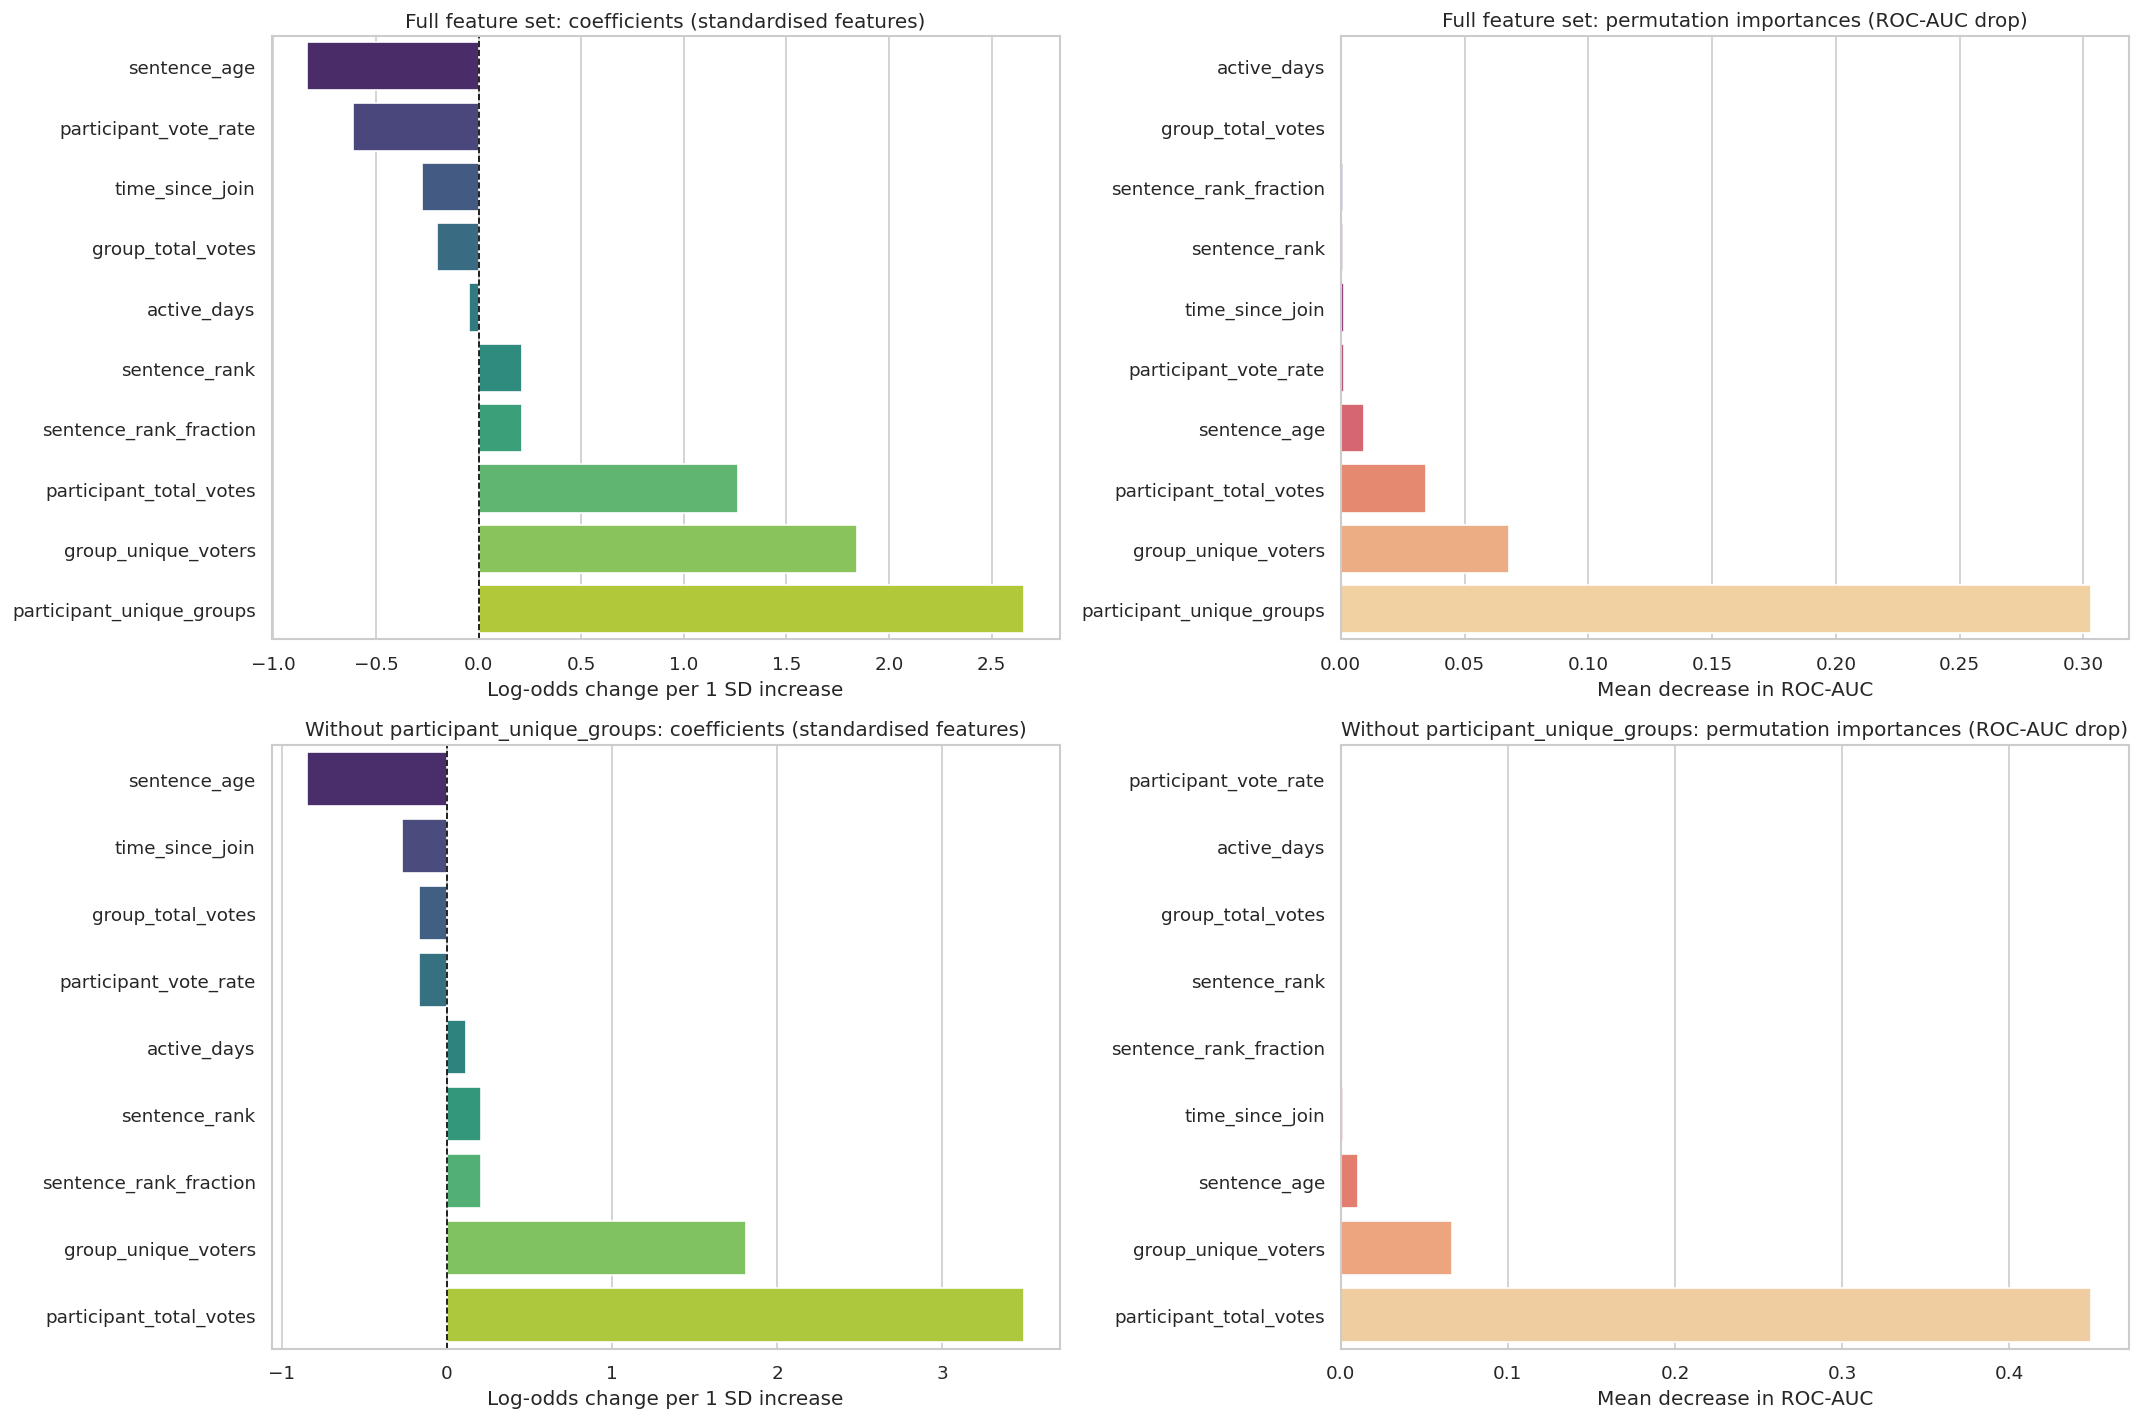

In [5]:

feature_importance_df = None
perm_importance_df = None
feature_importance_tables = []
perm_importance_tables = []
plot_payload = []

if (
    "propensity_models" in globals()
    and propensity_models
    and not exposure_df.empty
):
    for key, model in propensity_models.items():
        label = model.get("label", key)
        clf = model.get("clf")
        X_norm = model.get("X_norm")
        y_vals = model.get("y")
        feature_cols = model.get("feature_cols", [])
        if clf is None or X_norm is None or y_vals is None:
            print(
                f"Skipping feature importance for {label} because the logistic model was unavailable."
            )
            continue

        coef = pd.Series(clf.coef_[0], index=feature_cols)
        odds = np.exp(coef)
        coef_df = (
            pd.DataFrame(
                {
                    "feature": feature_cols,
                    "coefficient": coef.values,
                    "odds_ratio": odds.values,
                    "abs_coefficient": coef.abs().values,
                }
            )
            .sort_values("abs_coefficient", ascending=False)
            .reset_index(drop=True)
        )
        coef_df["model"] = label
        feature_importance_tables.append(coef_df)

        from sklearn.inspection import permutation_importance

        perm_result = permutation_importance(
            clf, X_norm, y_vals, n_repeats=15, random_state=42, scoring="roc_auc", n_jobs=1
        )
        perm_df = (
            pd.DataFrame(
                {
                    "feature": feature_cols,
                    "importance_mean": perm_result.importances_mean,
                    "importance_std": perm_result.importances_std,
                }
            )
            .sort_values("importance_mean", ascending=False)
            .reset_index(drop=True)
        )
        perm_df["model"] = label
        perm_importance_tables.append(perm_df)

        plot_payload.append(
            (
                label,
                coef_df.head(10).sort_values("coefficient"),
                perm_df.head(10).sort_values("importance_mean"),
            )
        )

    if feature_importance_tables:
        feature_importance_df = pd.concat(feature_importance_tables, ignore_index=True)
        display(feature_importance_df)
    if perm_importance_tables:
        perm_importance_df = pd.concat(perm_importance_tables, ignore_index=True)
        display(perm_importance_df)
    if plot_payload:
        fig, axes = plt.subplots(len(plot_payload), 2, figsize=(18, 6 * len(plot_payload)))
        if len(plot_payload) == 1:
            axes = np.array([axes])
        for row, (label, top_coef, top_perm) in enumerate(plot_payload):
            sns.barplot(
                data=top_coef,
                x="coefficient",
                y="feature",
                palette="viridis",
                ax=axes[row, 0],
            )
            axes[row, 0].axvline(0, color="black", linewidth=1, linestyle="--")
            axes[row, 0].set_title(f"{label}: coefficients (standardised features)")
            axes[row, 0].set_xlabel("Log-odds change per 1 SD increase")
            axes[row, 0].set_ylabel("")

            sns.barplot(
                data=top_perm,
                x="importance_mean",
                y="feature",
                palette="magma",
                ax=axes[row, 1],
            )
            axes[row, 1].set_title(f"{label}: permutation importances (ROC-AUC drop)")
            axes[row, 1].set_xlabel("Mean decrease in ROC-AUC")
            axes[row, 1].set_ylabel("")

        plt.tight_layout()
else:
    print("Feature importances unavailable because the logistic exposure model was not fit.")



### Exposure propensity diagnostics

Both propensity configurations—the full feature set and the baseline without `participant_unique_groups`—blend participant engagement (total votes cast, unique groups, voting rate, and time since joining) with group visibility (ballots, unique voters, chronological rank) and recency features before fitting a class-balanced logistic regression. The printed ROC-AUC, average precision, and Brier score quantify how well each model separates eligible votes from misses, while the per-row plots visualise the probability gap for every specification.


/tmp/ipykernel_10309/1279678779.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


/tmp/ipykernel_10309/1279678779.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


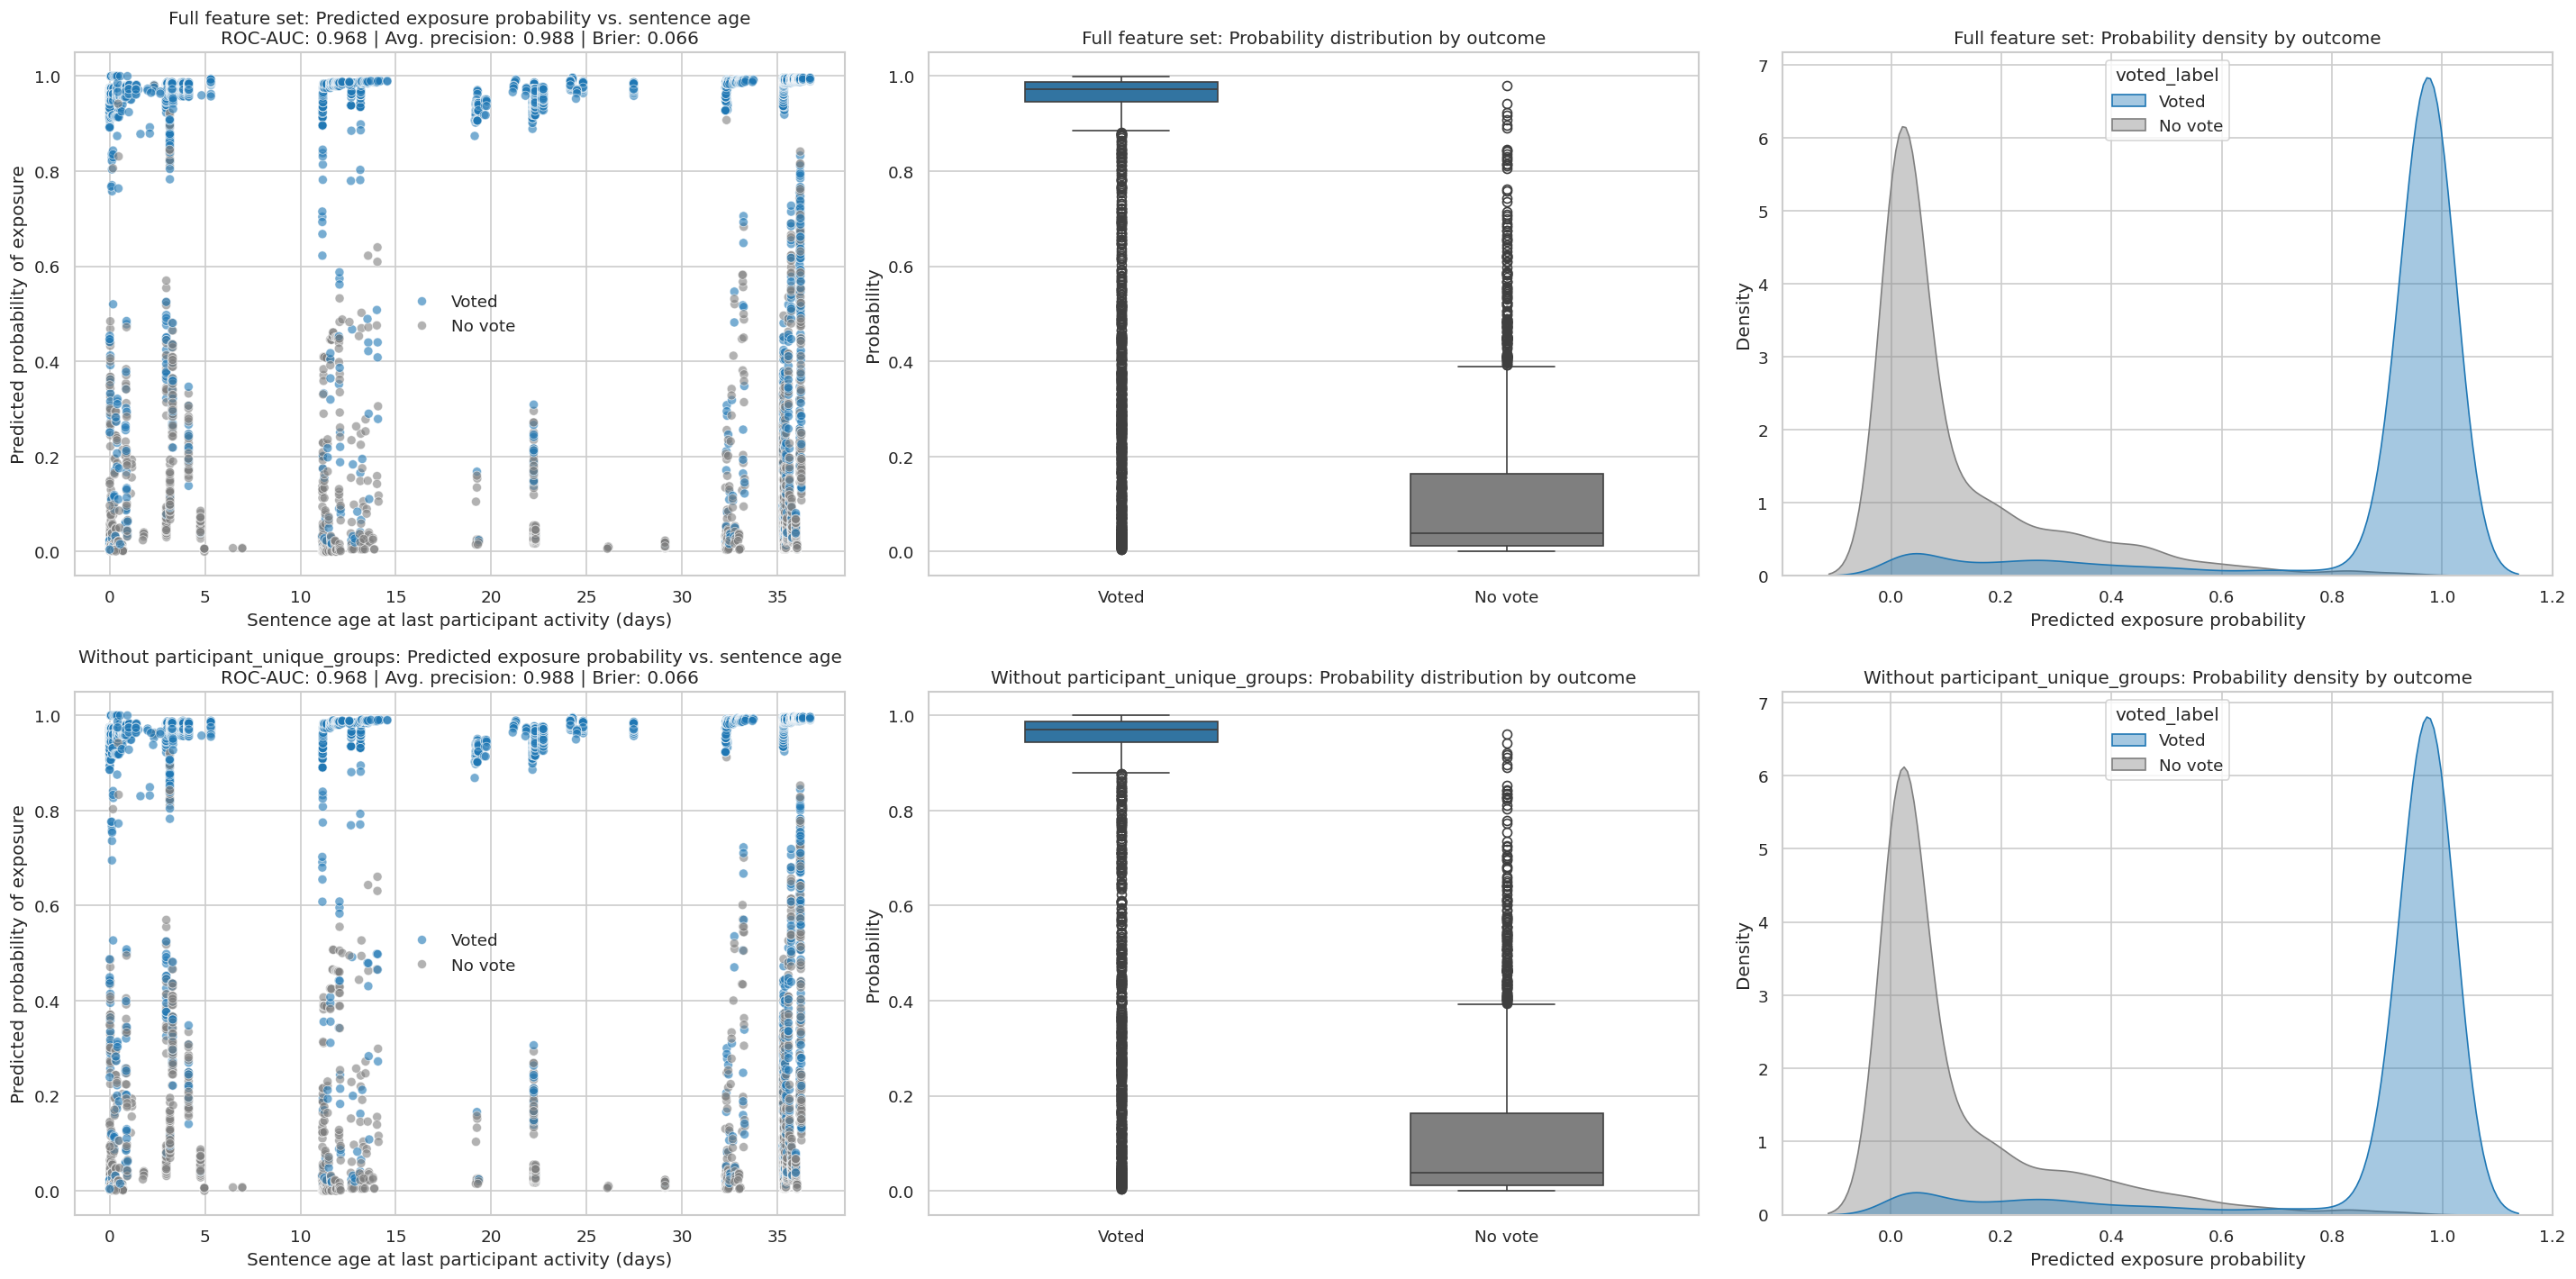

In [6]:

available_propensity_plots = []
if (
    not exposure_df.empty
    and "propensity_models" in globals()
    and propensity_models
):
    for key, model in propensity_models.items():
        col_name = f"probability_{key}"
        if col_name not in exposure_df:
            continue
        plot_df = exposure_df.dropna(subset=[col_name]).copy()
        if plot_df.empty:
            continue
        plot_df["probability"] = plot_df[col_name]
        plot_df["voted_label"] = plot_df["voted"].map({0: "No vote", 1: "Voted"})
        available_propensity_plots.append((key, model, plot_df))

if available_propensity_plots:
    n_models = len(available_propensity_plots)
    fig, axes = plt.subplots(n_models, 3, figsize=(24, 6 * n_models))
    if n_models == 1:
        axes = np.array([axes])
    palette = {"No vote": "#7f7f7f", "Voted": "#1f77b4"}

    for row, (key, model, plot_df) in enumerate(available_propensity_plots):
        label = model.get("label", key)
        metrics = model.get("diagnostics", {})
        metric_bits = []
        for display_label, metric_key in [
            ("ROC-AUC", "roc_auc"),
            ("Avg. precision", "average_precision"),
            ("Brier", "brier"),
        ]:
            value = metrics.get(metric_key)
            if value is not None and not pd.isna(value):
                metric_bits.append(f"{display_label}: {value:.3f}")
        subtitle = " | ".join(metric_bits)

        title = f"{label}: Predicted exposure probability vs. sentence age"
        if subtitle:
            title += "\n" + subtitle

        sns.scatterplot(
            data=plot_df,
            x="sentence_age",
            y="probability",
            hue="voted_label",
            palette=palette,
            alpha=0.6,
            ax=axes[row, 0],
        )
        axes[row, 0].set_title(title)
        axes[row, 0].set_xlabel("Sentence age at last participant activity (days)")
        axes[row, 0].set_ylabel("Predicted probability of exposure")
        axes[row, 0].legend(frameon=False)

        sns.boxplot(
            data=plot_df,
            x="voted_label",
            y="probability",
            palette=palette,
            width=0.5,
            ax=axes[row, 1],
        )
        axes[row, 1].set_title(f"{label}: Probability distribution by outcome")
        axes[row, 1].set_xlabel("")
        axes[row, 1].set_ylabel("Probability")

        sns.kdeplot(
            data=plot_df,
            x="probability",
            hue="voted_label",
            fill=True,
            common_norm=False,
            alpha=0.4,
            palette=palette,
            ax=axes[row, 2],
        )
        axes[row, 2].set_title(f"{label}: Probability density by outcome")
        axes[row, 2].set_xlabel("Predicted exposure probability")
        axes[row, 2].set_ylabel("Density")

    plt.tight_layout()
    plt.show()
else:
    print("Not enough propensity estimates to visualise.")


## 3. Vote Embedding via Signed Matrix Factorization with Propensity Weighting

Our next goal is to represent each sentence group by a low‑dimensional vector capturing how participants voted on it. We use a **signed matrix factorization** model with latent user and group factors (\(U\) and \(V\)) and biases (\(b_u\) and \(c_v\)). For each observed vote \(y_{ij}\) on group \(j\) by user \(i\), the score is

\[s_{ij} = U_i \cdot V_j + b_{u_i} + c_{v_j}\].

We minimise a weighted loss:

* **Agree/Disagree (±1):** logistic loss \(\log(1+\exp(-y\, s))\).
* **Pass (0):** quadratic loss \(w_0 \cdot s^2\) pulling the score toward neutrality, with hyperparameter \(w_0\).

Each term is weighted by the **inverse propensity** \(1/p_{ij}\) computed earlier to correct for selection bias. We also include \(\ell_2\) regularisation on the latent factors. Optimisation is performed with stochastic gradient descent (SGD).  

The resulting item factors \(V\) serve as our vote‑based embeddings for each sentence group.


In [7]:

from IPython.display import display

# Hyperparameters
k = 16  # latent dimensionality
lambda_reg = 1e-4  # regularisation strength
w0 = 0.3  # weight for neutral votes
epochs = 200
learning_rate = 0.02
PROPENSITY_FLOOR = 5e-2  # cap propensity weights at 20x
VOTE_COUNT_FLOOR = 1.0
MAX_GRAD_NORM = 10.0
MAX_BIAS_GRAD = 10.0

# Map users and groups to indices
user_to_idx = {u: idx for idx, u in enumerate(users)}
group_to_idx = {g: idx for idx, g in enumerate(groups)}

# Vote counts per group (clip at 1 to avoid divide-by-zero)
group_vote_counts = (
    votes_df.groupby("group_id")["vote"].size().reindex(groups, fill_value=0).clip(lower=1)
)

# Build list of training records containing both propensity and vote counts
train_records = []
for _, row in votes_df.iterrows():
    u_idx = user_to_idx[row["participant_id"]]
    g_idx = group_to_idx[row["group_id"]]
    y_val = row["vote"]
    p_val = p_hat.loc[row["participant_id"], row["group_id"]]
    if pd.notna(p_val) and p_val > 0:
        train_records.append(
            {
                "u_idx": u_idx,
                "g_idx": g_idx,
                "vote": y_val,
                "p_hat": float(p_val),
                "vote_count": float(group_vote_counts.loc[row["group_id"]]),
            }
        )

num_users = len(users)
num_items = len(groups)


def logistic_loss_and_grad(z, y_val):
    '''Stable log-loss and gradient for signed votes.'''
    if z >= 0:
        exp_neg_z = np.exp(-z)
        loss = np.log1p(exp_neg_z)
        grad = -y_val * exp_neg_z / (1 + exp_neg_z)
    else:
        exp_z = np.exp(z)
        loss = -z + np.log1p(exp_z)
        grad = -y_val / (1 + exp_z)
    return loss, grad


def clip_gradients(vec, max_norm):
    norm = np.linalg.norm(vec)
    if norm > max_norm and norm > 0:
        vec *= max_norm / norm
    return vec


def train_vote_embeddings(train_records, weight_by="propensity", seed=42):
    '''Train vote embeddings under a chosen importance-weighting scheme.'''
    assert weight_by in {"propensity", "vote_count"}, "Unknown weighting"
    rng = np.random.default_rng(seed)

    U = 0.1 * rng.standard_normal((num_users, k))
    V = 0.1 * rng.standard_normal((num_items, k))
    b_u = np.zeros(num_users)
    c_v = np.zeros(num_items)

    epoch_losses = []
    for epoch in range(epochs):
        order = rng.permutation(len(train_records))
        total_loss = 0.0
        for idx in order:
            record = train_records[idx]
            u_idx = record["u_idx"]
            g_idx = record["g_idx"]
            y_val = record["vote"]
            weight_value = record["p_hat"] if weight_by == "propensity" else record["vote_count"]
            floor = PROPENSITY_FLOOR if weight_by == "propensity" else VOTE_COUNT_FLOOR
            weight_scale = 1.0 / max(weight_value, floor)

            s = np.dot(U[u_idx], V[g_idx]) + b_u[u_idx] + c_v[g_idx]
            if y_val == 1 or y_val == -1:
                z = y_val * np.clip(s, -50, 50)
                loss, grad_s = logistic_loss_and_grad(z, y_val)
            else:
                s_clipped = np.clip(s, -10, 10)
                loss = w0 * (s_clipped**2)
                grad_s = 2 * w0 * s_clipped

            loss *= weight_scale
            grad_s *= weight_scale
            total_loss += loss

            grad_u = grad_s * V[g_idx] + 2 * lambda_reg * U[u_idx]
            grad_v = grad_s * U[u_idx] + 2 * lambda_reg * V[g_idx]
            grad_u = clip_gradients(grad_u, MAX_GRAD_NORM)
            grad_v = clip_gradients(grad_v, MAX_GRAD_NORM)
            grad_bias = np.clip(grad_s, -MAX_BIAS_GRAD, MAX_BIAS_GRAD)

            U[u_idx] -= learning_rate * grad_u
            V[g_idx] -= learning_rate * grad_v
            b_u[u_idx] -= learning_rate * grad_bias
            c_v[g_idx] -= learning_rate * grad_bias

        epoch_losses.append(total_loss)
        if (epoch + 1) % 50 == 0:
            print(f"{weight_by}: epoch {epoch+1}/{epochs}, weighted loss = {total_loss:.4f}")

    return {
        "U": U,
        "V": V,
        "b_u": b_u,
        "c_v": c_v,
        "epoch_losses": epoch_losses,
    }


def evaluate_embeddings(train_records, model_params):
    '''Compute diagnostics that do not re-use the training weights.'''
    U = model_params["U"]
    V = model_params["V"]
    b_u = model_params["b_u"]
    c_v = model_params["c_v"]

    sign_hits = 0
    sign_total = 0
    neutral_sq = 0.0
    neutral_total = 0
    unweighted_loss = 0.0

    for record in train_records:
        u_idx = record["u_idx"]
        g_idx = record["g_idx"]
        y_val = record["vote"]
        s = np.dot(U[u_idx], V[g_idx]) + b_u[u_idx] + c_v[g_idx]

        if y_val in (1, -1):
            unweighted_loss += np.log1p(np.exp(-y_val * s))
            predicted_label = 1 if s >= 0 else -1
            if predicted_label == y_val:
                sign_hits += 1
            sign_total += 1
        else:
            unweighted_loss += w0 * (s**2)
            neutral_sq += s**2
            neutral_total += 1

    metrics = {
        "sign_accuracy": sign_hits / sign_total if sign_total else np.nan,
        "neutral_rmse": np.sqrt(neutral_sq / neutral_total) if neutral_total else np.nan,
        "mean_unweighted_loss": unweighted_loss / len(train_records) if train_records else np.nan,
    }
    return metrics


if not train_records:
    raise ValueError("No training records available after propensity filtering.")

models = {}
comparison_rows = []
for label, key, seed in [
    ("Inverse propensity", "propensity", 42),
    ("Inverse total votes", "vote_count", 84),
]:
    model = train_vote_embeddings(train_records, weight_by=key, seed=seed)
    diagnostics = evaluate_embeddings(train_records, model)
    models[label] = {**model, "metrics": diagnostics, "weight_key": key}
    comparison_rows.append(
        {
            "weighting": label,
            "final_weighted_loss": model["epoch_losses"][-1],
            "sign_accuracy": diagnostics["sign_accuracy"],
            "neutral_rmse": diagnostics["neutral_rmse"],
            "mean_unweighted_loss": diagnostics["mean_unweighted_loss"],
        }
    )

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

best_row = comparison_df.sort_values("mean_unweighted_loss").iloc[0]
best_label = best_row["weighting"]
print(f"Selected weighting: {best_label} (min mean unweighted loss)")

best_model = models[best_label]
U = best_model["U"]
V = best_model["V"]
b_u = best_model["b_u"]
c_v = best_model["c_v"]
vote_weighting_strategy = best_label
vote_embeddings = V.copy()


propensity: epoch 50/200, weighted loss = 737.2081


propensity: epoch 100/200, weighted loss = 579.2424


propensity: epoch 150/200, weighted loss = 504.8392


propensity: epoch 200/200, weighted loss = 454.0554


vote_count: epoch 50/200, weighted loss = 23.4135


vote_count: epoch 100/200, weighted loss = 22.0277


vote_count: epoch 150/200, weighted loss = 21.3228


vote_count: epoch 200/200, weighted loss = 20.9034


,weighting,final_weighted_loss,sign_accuracy,neutral_rmse,mean_unweighted_loss
0,Inverse propensity,454.055360,0.992769,0.390804,0.063228
1,Inverse total votes,20.903417,0.800620,0.452600,0.368410


Selected weighting: Inverse propensity (min mean unweighted loss)


The table above compares the inverse-propensity baseline against weighting by the raw vote count. We pick the scheme with the lower unweighted reconstruction loss to carry forward in the analysis (recorded in `vote_weighting_strategy`).

## 4. Text Embedding and Feature Fusion

While vote embeddings capture participants' opinions, we also want to incorporate **semantic information** from the sentences themselves. We obtain sentence embeddings using the same bi‑encoder as in the deduplication step (if available).  

We standardise (zero‑mean/ unit‑variance) both vote and text embeddings and concatenate them. A normalisation to unit length ensures that cosine distance is equivalent to Euclidean distance on the sphere. We then cluster the fused representations using **HDBSCAN**, which automatically determines the number of clusters and handles noise. If `hdbscan` is unavailable, we fall back to `k`‑means.

After clustering, we compute centroids of each topic and apply agglomerative clustering to obtain a hierarchy of topics (super‑topics). The labels `topic` and `super_topic` are added to the `sentences_df` DataFrame.


In [8]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize

## Text embedding
text_embeddings = None
if "bi_encoder" in globals() and bi_encoder is not None:
    try:
        sentence_embeddings = bi_encoder.encode(
            sentences_df["text"].tolist(),
            convert_to_tensor=False,
            normalize_embeddings=True,
        )
        group_lookup = {g: idx for idx, g in enumerate(groups)}
        group_vectors = np.zeros((len(groups), sentence_embeddings.shape[1]), dtype=float)
        counts = np.zeros(len(groups), dtype=int)
        for emb, gid in zip(sentence_embeddings, sentences_df["group_id"].tolist()):
            idx = group_lookup.get(gid)
            if idx is None:
                continue
            group_vectors[idx] += emb
            counts[idx] += 1
        nonzero = counts > 0
        if np.any(nonzero):
            group_vectors[nonzero] /= counts[nonzero, None]
        text_embeddings = group_vectors if np.any(counts) else None
    except Exception as e:
        print("Error computing text embeddings:", e)

## Standardise vote and text embeddings
vote_scaled = None
if "vote_embeddings" in globals() and vote_embeddings is not None:
    vote_scaler = StandardScaler()
    vote_scaled = vote_scaler.fit_transform(vote_embeddings)

text_scaled = None
if text_embeddings is not None:
    text_scaler = StandardScaler()
    text_scaled = text_scaler.fit_transform(text_embeddings)

# Build feature matrix
if vote_scaled is not None and text_scaled is not None:
    features = np.hstack([vote_scaled, text_scaled])
elif vote_scaled is not None:
    features = vote_scaled
elif text_scaled is not None:
    features = text_scaled
else:
    raise ValueError("No features available for clustering.")

# Normalise to unit norm
features_norm = normalize(features)

## Clustering
cluster_labels = None
try:
    import hdbscan

    hdb = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5, metric="euclidean")
    cluster_labels = hdb.fit_predict(features_norm)
    valid = cluster_labels[cluster_labels >= 0]
    if valid.size == 0:
        raise ValueError("HDBSCAN returned only noise; fallback to k-means.")
    print("HDBSCAN identified", len(np.unique(valid)), "clusters.")
except Exception as e:
    print("HDBSCAN unavailable or insufficient structure, falling back to k-means. Reason:", e)
    K = min(10, max(2, features_norm.shape[0] // 3))
    km = KMeans(n_clusters=K, random_state=42)
    cluster_labels = km.fit_predict(features_norm)
    print("k-means formed", len(np.unique(cluster_labels)), "clusters.")

group_cluster_map = {g: int(label) for g, label in zip(groups, cluster_labels)}
sentences_df["topic"] = sentences_df["group_id"].map(group_cluster_map)

# Compute centroids for each cluster
clusters = np.unique(cluster_labels)
centroids = np.array(
    [features_norm[cluster_labels == c].mean(axis=0) for c in clusters]
)

# Hierarchical clustering on centroids
agg = AgglomerativeClustering(
    n_clusters=None, distance_threshold=0.5, metric="euclidean", linkage="average"
)
hier_labels = agg.fit_predict(centroids)
hier_map = {int(c): int(h) for c, h in zip(clusters, hier_labels)}
sentences_df["super_topic"] = sentences_df["topic"].map(hier_map)

# Persist group-level feature matrix for downstream analysis
group_features_norm = features_norm
group_ids_ordered = list(groups)

sentences_df[["sentence_id", "group_id", "topic", "super_topic"]].head()


HDBSCAN unavailable or insufficient structure, falling back to k-means. Reason: HDBSCAN returned only noise; fallback to k-means.
k-means formed 10 clusters.


/root/.cache/pypoetry/virtualenvs/taking-stock-facct-xWlJi2Mp-py3.12/lib/python3.12/site-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/root/.cache/pypoetry/virtualenvs/taking-stock-facct-xWlJi2Mp-py3.12/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/root/.cache/pypoetry/virtualenvs/taking-stock-facct-xWlJi2Mp-py3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/taking-stock-facct-xWlJi2Mp-py3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,sentence_id,group_id,topic,super_topic
6,0,0,0,5
7,1,1,3,4
8,2,2,1,8
9,3,3,8,1
10,4,4,3,4


## 5. Topic Labeling and Social Statistics

To make the discovered topics interpretable, we extract keywords and representative sentences. We employ **class‑based TF‑IDF (c‑TF‑IDF)**: for each topic, we concatenate all sentences in that cluster into a single document and compute TF‑IDF scores over the vocabulary. The top‑scoring n‑grams are selected as keywords.

We also present a few sentences closest to the cluster centroid in the fused embedding space.

In addition, we summarise the voting behaviour within each topic using the following statistics:

* **Coverage:** the proportion of eligible participants who actually voted on sentences in this topic.
* **Agree / Disagree / Pass:** the fraction of votes (among exposed participants) that were +1, -1 or 0, respectively.
* **Polarity:** the mean vote value (agree = +1, disagree = -1, pass = 0).
* **Controversy:** the entropy (base 3) of the agree/pass/disagree distribution; higher values indicate more mixed opinions.

These metrics help identify topics with strong consensus versus contentious topics.


In [9]:
import math

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer


def compute_ctfidf(texts, labels, ngram_range=(1, 3), top_k=10):
    unique_labels = np.unique(labels)
    docs = [' '.join(np.array(texts)[labels == label]) for label in unique_labels]
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words="english").fit(
        docs
    )
    tfidf_matrix = vectorizer.transform(docs)
    feature_names = np.array(vectorizer.get_feature_names_out())
    keywords = {}
    for i, label in enumerate(unique_labels):
        row = tfidf_matrix[i].toarray().flatten()
        idx = row.argsort()[::-1][:top_k]
        keywords[label] = feature_names[idx].tolist()
    return keywords


# Keywords per topic
keywords_per_topic = compute_ctfidf(
    sentences_df["text"].values,
    sentences_df["topic"].values,
    ngram_range=(1, 3),
    top_k=10,
)

# Representative sentences: nearest group centroids
rep_sentences = {}
if "group_ids_ordered" in globals():
    group_ids_array = np.array(group_ids_ordered)
    for c in clusters:
        group_mask = np.where(cluster_labels == c)[0]
        if group_mask.size == 0:
            continue
        centroid = centroids[np.where(clusters == c)[0][0]]
        dists = np.linalg.norm(group_features_norm[group_mask] - centroid, axis=1)
        nearest_group_indices = group_mask[np.argsort(dists)[:3]]
        nearest_group_ids = group_ids_array[nearest_group_indices]
        texts = (
            sentences_df[sentences_df["group_id"].isin(nearest_group_ids)]
            .sort_values("timestamp")["text"]
            .tolist()
        )
        rep_sentences[c] = texts[:3]
else:
    rep_sentences = {c: [] for c in clusters}


def compute_topic_stats(topic_id):
    idxs = sentences_df[sentences_df["topic"] == topic_id].index
    groups_in_topic = sentences_df.iloc[idxs]["group_id"].unique()
    elig_users = 0
    voted_users = 0
    agree_cnt = 0
    disagree_cnt = 0
    pass_cnt = 0
    for u in users:
        eligible_any = False
        votes_for_topic = []
        for g in groups_in_topic:
            if eligibility.loc[u, g]:
                eligible_any = True
                rows = votes_df[
                    (votes_df["participant_id"] == u) & (votes_df["group_id"] == g)
                ]
                if not rows.empty:
                    votes_for_topic.append(rows.iloc[0]["vote"])
        if eligible_any:
            elig_users += 1
            if votes_for_topic:
                voted_users += 1
                # pick strongest vote for this topic
                v = sorted(votes_for_topic, key=lambda x: (abs(x), x), reverse=True)[0]
                if v == 1:
                    agree_cnt += 1
                elif v == -1:
                    disagree_cnt += 1
                else:
                    pass_cnt += 1
    coverage = voted_users / max(elig_users, 1)
    total = agree_cnt + disagree_cnt + pass_cnt
    if total > 0:
        agree_pct = agree_cnt / total
        disagree_pct = disagree_cnt / total
        pass_pct = pass_cnt / total
        polarity = (agree_cnt - disagree_cnt) / total
        probs = np.array([agree_pct, pass_pct, disagree_pct])
        entropy = -np.sum(probs * np.log(probs + 1e-12)) / np.log(3)
    else:
        agree_pct = disagree_pct = pass_pct = polarity = entropy = np.nan
    return {
        "coverage": coverage,
        "agree_pct": agree_pct,
        "disagree_pct": disagree_pct,
        "pass_pct": pass_pct,
        "polarity": polarity,
        "controversy": entropy,
    }


summary_rows = []
topic_stats = {c: compute_topic_stats(c) for c in clusters}

# Display summary per topic
for c in clusters:
    print(f"Topic {c}")
    print("  Keywords:", ", ".join(keywords_per_topic.get(c, [])))
    print("  Representative sentences:")
    for s in rep_sentences.get(c, []):
        print("   -", s)
    stats = topic_stats[c]
    coverage_txt = f"{stats['coverage']:.2%}"
    agree_txt = "nan" if np.isnan(stats["agree_pct"]) else f"{stats['agree_pct']:.1%}"
    disagree_txt = "nan" if np.isnan(stats["disagree_pct"]) else f"{stats['disagree_pct']:.1%}"
    pass_txt = "nan" if np.isnan(stats["pass_pct"]) else f"{stats['pass_pct']:.1%}"
    polarity_txt = "nan" if np.isnan(stats["polarity"]) else f"{stats['polarity']:.2f}"
    controversy_txt = "nan" if np.isnan(stats["controversy"]) else f"{stats['controversy']:.2f}"
    print(
        f"  Coverage: {coverage_txt}, Agree: {agree_txt}, Disagree: {disagree_txt}, Pass: {pass_txt}, Polarity: {polarity_txt}, Controversy: {controversy_txt}"
    )
    summary_rows.append(
        {
            "topic": int(c),
            "keywords": keywords_per_topic.get(c, []),
            "representatives": rep_sentences.get(c, []),
            "coverage": stats["coverage"],
            "agree_pct": stats["agree_pct"],
            "disagree_pct": stats["disagree_pct"],
            "pass_pct": stats["pass_pct"],
            "polarity": stats["polarity"],
            "controversy": stats["controversy"],
        }
    )

summary_df = pd.DataFrame(summary_rows).sort_values("topic").reset_index(drop=True)
summary_df


Topic 0
  Keywords: values, doing, facct doing, facct, values facct, values facct doing, community, expression values, respectful exchange interdisciplinary, respectful exchange
  Representative sentences:
   - FAccT is building a community that shares similar values
   - FAccT is doing well in sticking to their values
   - FAccT is doing well in selecting diverse locations that are fun and culturally enriched.
  Coverage: 88.28%, Agree: 92.0%, Disagree: 1.8%, Pass: 6.2%, Polarity: 0.90, Controversy: 0.29
Topic 1
  Keywords: workshops, industry, facct, years, panels workshops, panels, 24, ve, ve facct, doing
  Representative sentences:
   - 3 times I've been to FAccT (18, 23, 24) tech industry influence (e.g. who runs workshops) has been noticeable & sometimes problematic.
   - FAccT could require panels & workshops to be designed/led by representatives of that year's region. '24 had decent regional representation.
   - In 3 years I've been to FAccT it had plenty of industry input thro

,topic,keywords,representatives,coverage,agree_pct,disagree_pct,pass_pct,polarity,controversy
0,0,"[values, doing, facct doing, facct, values fac...",[FAccT is building a community that shares sim...,0.882812,0.920354,0.017699,0.061947,0.902655,0.291361
1,1,"[workshops, industry, facct, years, panels wor...","[3 times I've been to FAccT (18, 23, 24) tech ...",0.859375,0.672727,0.181818,0.145455,0.490909,0.780124
2,2,"[facct, volunteer, volunteer run, academics fa...","[FAccT should be free for phd students, FAccT ...",0.914062,0.811966,0.094017,0.094017,0.717949,0.558610
3,3,"[visa, facct, local, locations, attendees, mee...",[FAccT should NOT be repeatedly in visa-requir...,0.921875,0.864407,0.025424,0.110169,0.838983,0.420819
4,4,"[faact, conference, future collaborators, usef...",[Faact is mostly focused on a single disciplin...,0.843750,0.833333,0.027778,0.138889,0.805556,0.478472
5,5,"[room, facct, room nap, room facct exclusionar...","[FAccT should NOT be exclusionary, FAccT shoul...",0.843750,0.851852,0.027778,0.120370,0.824074,0.446906
6,6,"[conference, participatory, design, creating, ...",[FAccT is not doing well in providing tangible...,0.859375,0.845455,0.054545,0.100000,0.790909,0.483202
7,7,"[narratives, western, attention, topics, facct...",[FAccT should NOT be centred around western na...,0.796875,0.705882,0.107843,0.186275,0.598039,0.727353
8,8,"[sessions, poster, poster sessions, sessions f...","[FAccT should have poster sessions, the curren...",0.875000,0.830357,0.080357,0.089286,0.750000,0.521268
9,9,"[facct, waste facct, waste, plastic, plastic w...","[FAccT should be vegetarian, FAccT should NOT ...",0.859375,0.827273,0.081818,0.090909,0.745455,0.527639


### Topic-level visualisations

These plots cross-reference topic size, vote mix, and derived metrics to highlight which themes draw consensus versus controversy.

/tmp/ipykernel_10309/4064675720.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


/tmp/ipykernel_10309/4064675720.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


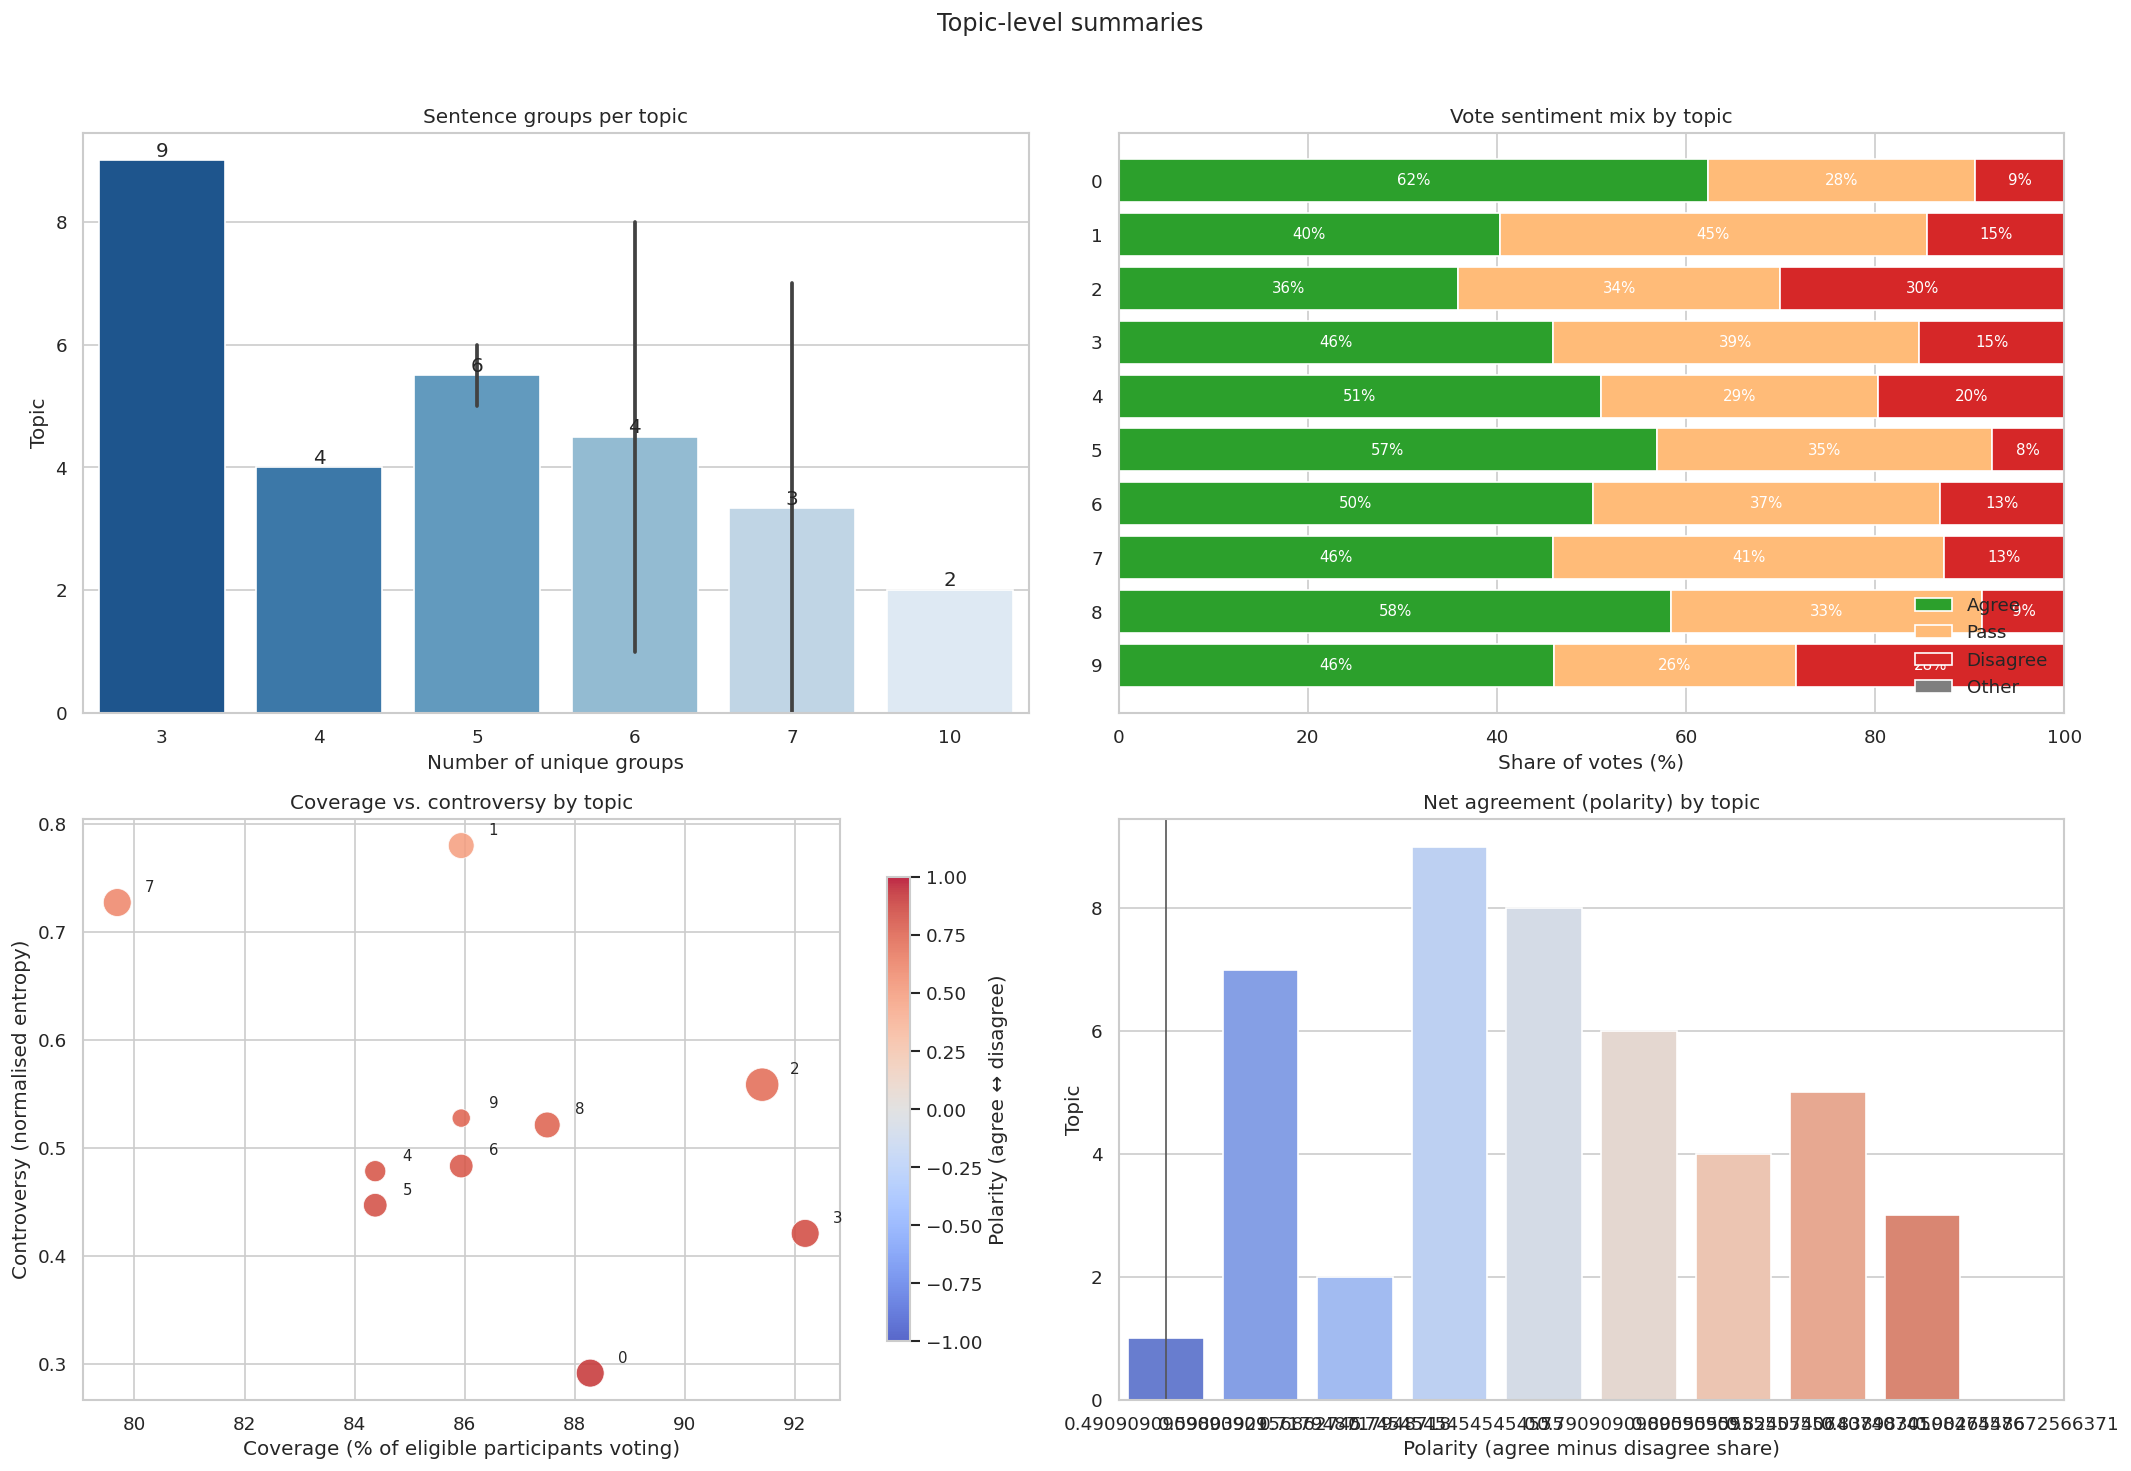

In [10]:
from matplotlib import colormaps

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Topic sizes
if "topic" in sentences_df.columns:
    topic_counts = (
        sentences_df.groupby("topic")
        .agg(groups=("group_id", "nunique"), sentences=("sentence_id", "nunique"))
        .reset_index()
        .sort_values("groups", ascending=False)
    )
else:
    topic_counts = pd.DataFrame()

if not topic_counts.empty:
    sns.barplot(
        data=topic_counts,
        x="groups",
        y="topic",
        palette="Blues_r",
        ax=axes[0, 0],
    )
    axes[0, 0].set_title("Sentence groups per topic")
    axes[0, 0].set_xlabel("Number of unique groups")
    axes[0, 0].set_ylabel("Topic")
    for container in axes[0, 0].containers:
        axes[0, 0].bar_label(container, fmt="%.0f")
else:
    axes[0, 0].axis("off")
    axes[0, 0].text(0.5, 0.5, "No topic assignments available.", ha="center", va="center")

# 2. Vote sentiment mix
if "topic" in sentences_df.columns:
    topic_votes = votes_df.merge(
        sentences_df[["group_id", "topic"]], on="group_id", how="left"
    )
else:
    topic_votes = pd.DataFrame()

if not topic_votes.empty:
    vote_map = {1: "Agree", -1: "Disagree", 0: "Pass"}
    topic_votes["vote_label"] = topic_votes["vote"].map(vote_map).fillna("Other")
    vote_share = (
        topic_votes.groupby(["topic", "vote_label"]).size().unstack(fill_value=0)
    )
    ordered_cols = ["Agree", "Pass", "Disagree", "Other"]
    vote_share = vote_share.reindex(columns=ordered_cols, fill_value=0)
    vote_share_pct = vote_share.div(vote_share.sum(axis=1), axis=0).fillna(0) * 100

    y_positions = np.arange(len(vote_share_pct.index))
    start = np.zeros(len(y_positions))
    colors = {"Agree": "#2ca02c", "Pass": "#ffbb78", "Disagree": "#d62728", "Other": "#7f7f7f"}

    for label in ordered_cols:
        values = vote_share_pct[label].values
        axes[0, 1].barh(
            y_positions,
            values,
            left=start,
            color=colors[label],
            label=label,
        )
        for i, v in enumerate(values):
            if v > 4:
                axes[0, 1].text(
                    start[i] + v / 2,
                    y_positions[i],
                    f"{v:.0f}%",
                    ha="center",
                    va="center",
                    color="white",
                    fontsize=9,
                )
        start += values

    axes[0, 1].set_yticks(y_positions)
    axes[0, 1].set_yticklabels(vote_share_pct.index.astype(int))
    axes[0, 1].invert_yaxis()
    axes[0, 1].set_xlim(0, 100)
    axes[0, 1].set_xlabel("Share of votes (%)")
    axes[0, 1].set_title("Vote sentiment mix by topic")
    axes[0, 1].legend(frameon=False, loc="lower right")
else:
    axes[0, 1].axis("off")
    axes[0, 1].text(0.5, 0.5, "No topic-level vote data available.", ha="center", va="center")

# Prepare summary merge
if 'topic' in summary_df.columns:
    summary_plot = summary_df.copy()
else:
    summary_plot = pd.DataFrame()

if not summary_plot.empty:
    summary_plot = summary_plot.merge(topic_counts, on="topic", how="left")

# 3. Coverage vs controversy scatter
if not summary_plot.empty and summary_plot[["coverage", "controversy"]].notna().any().any():
    scatter_df = summary_plot.dropna(subset=["coverage", "controversy"]).copy()
    if not scatter_df.empty:
        scatter_df["coverage_pct"] = scatter_df["coverage"] * 100
        scatter_sizes = np.clip(scatter_df["groups"].fillna(1), 1, None) * 40
        cmap = colormaps["coolwarm"]
        sc = axes[1, 0].scatter(
            scatter_df["coverage_pct"],
            scatter_df["controversy"],
            s=scatter_sizes,
            c=scatter_df["polarity"],
            cmap=cmap,
            vmin=-1,
            vmax=1,
            alpha=0.85,
            edgecolor="white",
            linewidth=0.5,
        )
        for _, row in scatter_df.iterrows():
            axes[1, 0].text(
                row["coverage_pct"] + 0.5,
                row["controversy"] + 0.01,
                int(row["topic"]),
                fontsize=9,
            )
        axes[1, 0].set_xlabel("Coverage (% of eligible participants voting)")
        axes[1, 0].set_ylabel("Controversy (normalised entropy)")
        axes[1, 0].set_title("Coverage vs. controversy by topic")
        cbar = plt.colorbar(sc, ax=axes[1, 0], shrink=0.8)
        cbar.set_label("Polarity (agree ↔ disagree)")
    else:
        axes[1, 0].axis("off")
        axes[1, 0].text(0.5, 0.5, "Insufficient summary metrics for scatter plot.", ha="center", va="center")
else:
    axes[1, 0].axis("off")
    axes[1, 0].text(0.5, 0.5, "Insufficient summary metrics for scatter plot.", ha="center", va="center")

# 4. Polarity bar chart
if not summary_plot.empty and summary_plot["polarity"].notna().any():
    polarity_df = summary_plot.dropna(subset=["polarity"]).sort_values("polarity")
    sns.barplot(
        data=polarity_df,
        x="polarity",
        y="topic",
        palette="coolwarm",
        ax=axes[1, 1],
    )
    axes[1, 1].axvline(0, color="#555555", linewidth=1)
    axes[1, 1].set_title("Net agreement (polarity) by topic")
    axes[1, 1].set_xlabel("Polarity (agree minus disagree share)")
    axes[1, 1].set_ylabel("Topic")
else:
    axes[1, 1].axis("off")
    axes[1, 1].text(0.5, 0.5, "Polarity scores unavailable.", ha="center", va="center")

plt.suptitle("Topic-level summaries", y=1.02)
plt.tight_layout()
plt.show()


## Conclusion

This notebook demonstrated an end‑to‑end approach to analysing single‑sentence submissions with crowd‑sourced votes. We handled semantic redundancy via paraphrase mining, estimated exposure probabilities to correct for non‑uniform visibility, learned vote‑driven embeddings through signed matrix factorisation weighted by inverse propensities, fused them with semantic sentence embeddings, clustered the fused vectors to find topics, and labelled those topics with keywords and social statistics.

The techniques showcased here are modular: you can swap out the embedding models, use alternative exposure models or matrix factorisation algorithms, or experiment with different clustering methods. The general principle remains: **model exposure**, **learn meaningful representations**, **cluster to discover structure**, and **provide interpretable summaries**.
